In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm


# Keys To Build a Predictive Model

1. Don't include all the X's. It leads overfitting.
2. Use a validation set to evaluate performance.
3. Just include one colinear variable and remove the rest.
4. Adding more X's always improve R^2 (as well as the risk of overfitting), so use adjusted R^2 instead.


Recall model equation:

$$
Y = b_0 + b_1x_1 + b_2x_2...b_kx_k + \epsilon
$$

$$
Y \sim N(\mu,\sigma^2); \quad \epsilon \sim N(0,\sigma^2)
$$

In [2]:
url = "https://raw.githubusercontent.com/GTPB/PSLS20/master/data/fev.txt"
data = pd.read_csv(url, sep="\t")
data["gender"] = data["gender"].map({"f": 0, "m": 1})
data.head(3)

,age,fev,height,gender,smoking
0,9,1.708,57.0,0,0
1,8,1.724,67.5,0,0
2,7,1.720,54.5,0,0


In [3]:
model0 = smf.ols(formula = "fev ~ smoking", data = data).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:                    fev   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     30.65
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           4.60e-08
Time:                        11:55:41   Log-Likelihood:                -731.10
No. Observations:                 606   AIC:                             1466.
Df Residuals:                     604   BIC:                             1475.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6346      0.035     75.943      0.0

The `smoking` is a significant predictor of FEV. It has p-value < 0.05. The standard error is 0.1. In the next step, we will include the confounding variable `age`. (As age increases people tend to smoke more). It can be displayed via the correlation coefficient:

In [4]:
data[["smoking","age"]].corr()

,smoking,age
smoking,1.000000,0.400417
age,0.400417,1.000000


0.4 correlation suggests that there is a medium correlation between these variables which we typically see in confounding variables. Before including `age` in our model, let's check whether `age` is an important predictor:

<Axes: xlabel='age', ylabel='fev'>

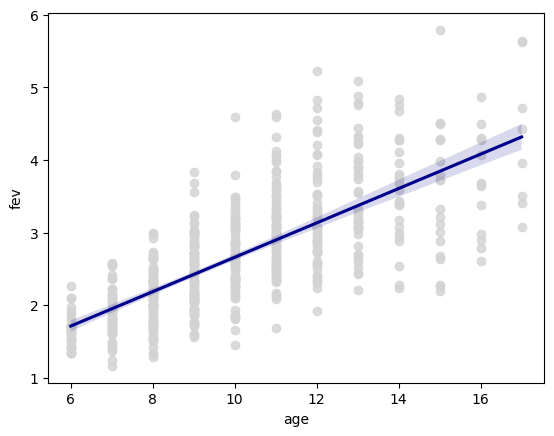

In [5]:
sns.regplot(x="age", y="fev", data=data, line_kws={"color": "darkblue"}, scatter_kws={"color": "lightgrey"})

It is an important predictor so let's include it on our model.

In [6]:
model1 = smf.ols(formula = "fev ~ age + smoking", data = data).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    fev   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     349.3
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          1.80e-101
Time:                        11:55:41   Log-Likelihood:                -512.97
No. Observations:                 606   AIC:                             1032.
Df Residuals:                     603   BIC:                             1045.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2040      0.099      2.052      0.0

The p-values of the model1 suggest that both `age` and `smoking` variable are significant. Since `age` is a confounding variable, the standard error of `smoking` did not increased (inflated) significantly.

Now we will include `height` variable. But let's analyze it first:

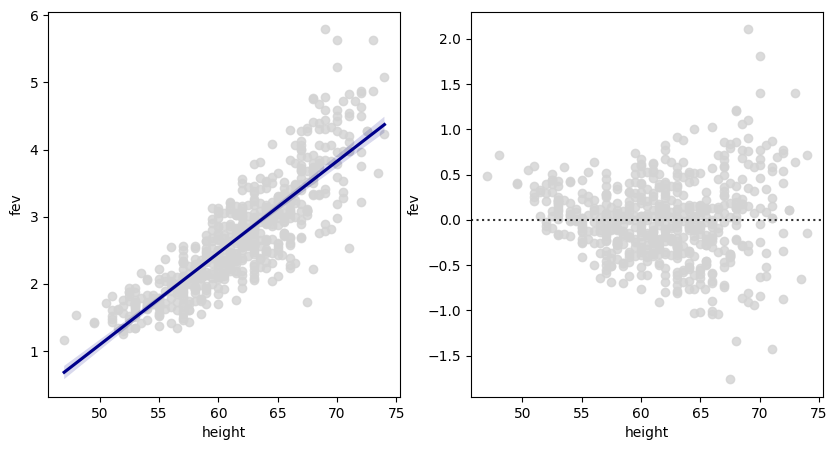

In [7]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
sns.regplot(x="height", y="fev", data=data, line_kws={"color": "darkblue"}, scatter_kws={"color": "lightgrey"},ax = ax[0])
sns.residplot(x = "height", y = "fev", data = data, line_kws={"color": "darkblue"}, scatter_kws={"color": "lightgrey"})
plt.show()

`Height` is strongly correlated with `fev`. Let's check the correlation between `age` and `height`:

In [8]:
data[["age","height"]].corr()

,age,height
age,1.000000,0.757948
height,0.757948,1.000000


This is expected. As `age` increases, `height` also increases. We need to see whether colinearity exists between these variables.

In [9]:
X = sm.add_constant(data[["age", "height", "smoking","gender"]])

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_df

,feature,VIF
0,const,207.924778
1,age,2.638383
2,height,2.461848
3,smoking,1.205689
4,gender,1.055816


Although `height` and `age` are correlated, they are not colinear. This can be seen from the VIF values. Let's include `height` in our model.

In [10]:
model2 = smf.ols(formula = "fev ~ age + height + smoking", data = data).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    fev   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     591.2
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          6.13e-179
Time:                        11:55:41   Log-Likelihood:                -330.17
No. Observations:                 606   AIC:                             668.3
Df Residuals:                     602   BIC:                             686.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9611      0.243    -20.437      0.0

Especially from the residual plot it could be seen that as `height` increases, the error on `FEV` also increase. Therefore this time we will include the `square of the height` in our model as well. While including the `square of height`, we won't drop `height` from the model because only including the `square of height` will intercept the effect of `height` on `FEV` in a U shape. Including both enables us to capture larger deviations in `FEV` in larger `height` values.

In [11]:
model3 = smf.ols(formula = "fev ~ age + height + I(height**2) +smoking", data = data).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    fev   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     486.9
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          6.60e-187
Time:                        11:55:41   Log-Likelihood:                -308.35
No. Observations:                 606   AIC:                             626.7
Df Residuals:                     601   BIC:                             648.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.6633      1.899      4.

Let's check whether including the `square of height` in our model improved the model performance.

In [12]:
anova_lm(model2,model3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,602.0,105.497231,0.0,NaN,NaN,NaN
1,601.0,98.165912,1.0,7.331318,44.884443,4.813322e-11


p-value < 0.05 means that including the `square of height` in our model improved the model performance.

Now we will include `gender` in our model. But let's see whether it has a significant effect on `FEV`.

<Axes: xlabel='gender', ylabel='fev'>

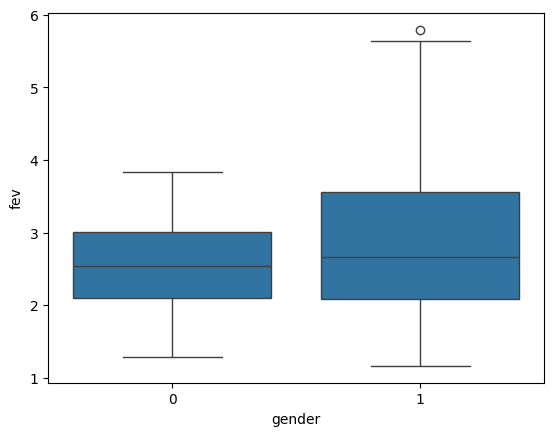

In [13]:
sns.boxplot(x = "gender", y = "fev", data = data)

It has a slight effect on `FEV`. After including `gender` in our model we shall see whether it has a significant effect on model performance or not via ANOVA.

In [14]:
model4 = smf.ols(formula = "fev ~ age + height + I(height**2) +smoking + gender", data = data).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                    fev   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     393.5
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          1.01e-186
Time:                        11:55:42   Log-Likelihood:                -305.59
No. Observations:                 606   AIC:                             623.2
Df Residuals:                     600   BIC:                             649.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.3017      1.979      3.

In [15]:
anova_lm(model3,model4)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,601.0,98.165912,0.0,NaN,NaN,NaN
1,600.0,97.276414,1.0,0.889498,5.486418,0.019491


`Gender` has a significant effect on model performance so we will include it on our model.

As a side note, we only should compare the models statistically when we are not sure about the difference. Because the more tests we do, the more likely we make a type I error. A correction is needed as we do more tests.

References:

StatsMarines Lecture 4.4: Model Building and Variable Selection: Example Effect Size Model in R
